# installing Package and Importing Libraries

In [ ]:
!pip3 install tensorflow==2.2
!pip3 install keras==2.3.1
!pip3 install -U segmentation-models

In [ ]:
## Set enviroment with tf.keras, or It will throw a error for keras.
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
from segmentation_models import Unet
import tensorflow_datasets as tfds
import tarfile
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import tensorflow as tf
from random import shuffle
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn import model_selection
from google.colab.patches import cv2_imshow

# Download the Data and Extract the Data

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [ ]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

# Prepare paths of input images and target segmentation masks

In [ ]:
import os

input_dir = 'images/'
target_dir = 'annotations/trimaps/'
img_size = (256, 256)
num_classes = 4
batch_size = 32

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith('.jpg')])


target_img_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith('.png') and not fname.startswith('.')])

In [ ]:
print('Number of samples:', len(input_img_paths), '|', len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
  print(input_path, '|', target_path)

Number of samples: 7390 | 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


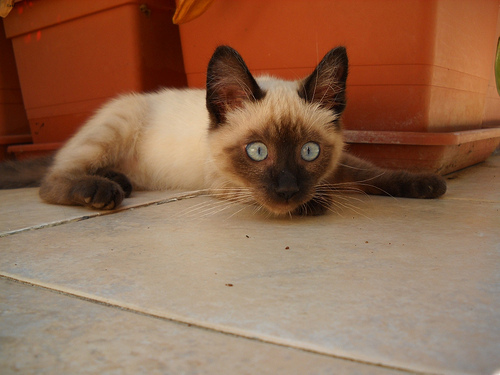

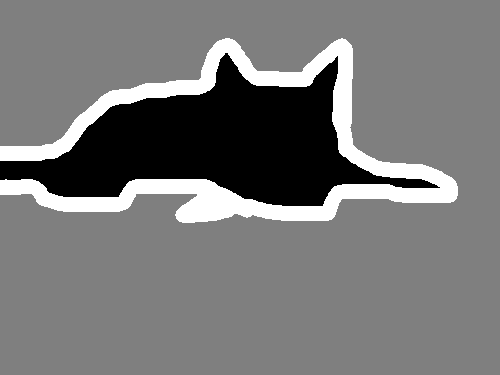

In [ ]:
# Display input image #7
display(Image(filename=input_img_paths[2000]))

# Display auto-constrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[2000]))
display(img)

# Shuffling the Paths; Prepare it for Train-Test Split

In [ ]:
# shuffle the paths and prepare train-test split
random.seed(42)

temp = list(zip(input_img_paths, target_img_paths))
random.shuffle(temp)
res1, res2 = zip(*temp)

input_img_paths = res1
target_img_paths = res2

## Loading the Data into Array for Training

In [ ]:
###### Data input part.
X = []
count = 0
for i in input_img_paths:
    # print(i)
    count += 1
    image = load_img(i, target_size = (224,224,3))
    input_arr = img_to_array(image)
    input_arr = np.array(input_arr)
    X.append(input_arr)
    if count == 500:
        break

In [ ]:
X = np.array(X)
X.shape

(500, 224, 224, 3)

In [ ]:
####### Data Class part.
Y = []
count = 0
for i in target_img_paths:
    # print(i)
    count += 1
    image = load_img(i, target_size = (224,224,3))
    input_arr = img_to_array(image)
    input_arr = np.array(input_arr)
    Y.append(input_arr)
    if count == 500:
        break

In [ ]:
Y = np.array(Y)
Y.shape

(500, 224, 224, 3)

In [ ]:
Y[0].shape

(224, 224, 3)

# Segmentation_models Package to train Image Segmentation on U_Net

In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = 0.20, random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 224, 224, 3),
 (100, 224, 224, 3),
 (400, 224, 224, 3),
 (100, 224, 224, 3))

## Using Resnet34 as its Backend

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [ ]:
# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [ ]:
X_train.shape, y_train.shape

((400, 224, 224, 3), (400, 224, 224, 3))

In [ ]:
X_test.shape, y_test.shape

((100, 224, 224, 3), (100, 224, 224, 3))

**ResNet34 is backbone, Encoder Weight is imagenet, classes are 3. Compiling the model with Adam optimizer, loss taken as Jacard Loss and metrics taken IOU score(i.e; Intersection Over Union)**

In [ ]:
model = Unet(BACKBONE, encoder_weights='imagenet', classes=3)
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [ ]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=10,
    validation_data=(X_test, y_test),
)

Epoch 1/10
25/25 [==============================] - 513s 21s/step - loss: -0.7766 - iou_score: 1.1199 - val_loss: 4952.6133 - val_iou_score: 0.6487
Epoch 2/10
25/25 [==============================] - 518s 21s/step - loss: -3.1082 - iou_score: 1.5528 - val_loss: -2.9869 - val_iou_score: 1.4041
Epoch 3/10
25/25 [==============================] - 507s 20s/step - loss: -5.6907 - iou_score: 1.6523 - val_loss: -203.9231 - val_iou_score: 1.4979
Epoch 4/10
25/25 [==============================] - 503s 20s/step - loss: -8.7510 - iou_score: 1.6807 - val_loss: -9.3074 - val_iou_score: 1.4157
Epoch 5/10
25/25 [==============================] - 511s 20s/step - loss: -12.4885 - iou_score: 1.7055 - val_loss: -72.5343 - val_iou_score: 1.7814
Epoch 6/10
25/25 [==============================] - 503s 20s/step - loss: -16.6247 - iou_score: 1.7129 - val_loss: -14.9895 - val_iou_score: 1.7006
Epoch 7/10
25/25 [==============================] - 514s 21s/step - loss: -21.4451 - iou_score: 1.7331 - val_loss: -

## Prediction Part

In [ ]:
# Applying the model on test_dataset to predict the output. Model will give us the mask as its prediction.
y_pred = model.predict(X_test)

In [ ]:
# a = 0
# for img, mask in zip(X_test, y_test):
#     print(img.shape, mask.shape)
#     break

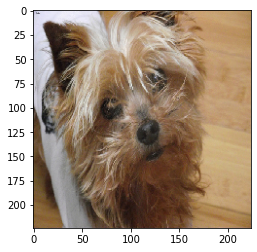

In [ ]:
# This is original Image.
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_test[1]))

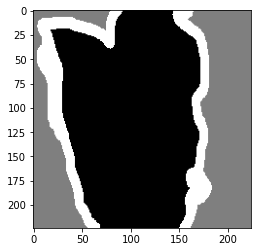

In [ ]:
# This is the true label of mask.
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_test[1]))

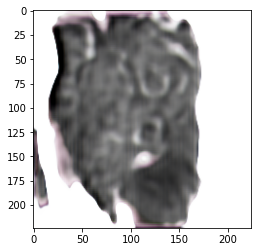

In [ ]:
# After 10 epochs running, our model capture this. This is predicted by model.
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_pred[1]))